Задание 10. A/B тестирование.


Шаг 1. Изучите материалы лекционных и практических занятий по темам раздела 6.

Шаг 2. Выполните A/B тестирование по предложенному датасету (алгоритм выполнения представлен в практическом занятии по теме 6.1).

Шаг 3. Опубликуйте файл расширения ipynb на платформе Odin.


Кейс: a/b-тест для мобильного приложения.

Имеется мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы принято решение провести A/B-тест.   

Договорились принять решение по результатам A/B-теста.
Пользователей разбили на 2 группы: 247 -- контрольная группа со старыми шрифтами (это другая группа, по сравнению с разобранной); 248 -- экспериментальная с новыми шрифтами.

Описание данных

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

Инструкция по выполнению проекта

Шаг 1. Загрузите данные
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовьте данные
- Корректировка заголовков;
- Типы данных;
- Аномалии пропуски.

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

**Шаг 1.** Загрузите данные
- Знакомство с данными;
- Корректность a/b-теста.

In [ ]:
# Подключаем библиотеки

import pandas as pd
import numpy as np

import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Загружаем данные

df = pd.read_csv('/content/ab_test_home.csv')
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
2,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
3,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248
4,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247
...,...,...,...,...
163817,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247
163818,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248
163819,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248
163820,OffersScreenAppear,5317814261427487562,2019-08-07 21:10:08,248


In [ ]:
# Смотрим информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       163822 non-null  object
 1   DeviceIDHash    163822 non-null  int64 
 2   EventTimestamp  163822 non-null  object
 3   ExpId           163822 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.0+ MB


In [ ]:
# Проверяем распределение клинетов по группам теста (должно быть примерно одинаково)

df.ExpId.value_counts()

248    85747
247    78075
Name: ExpId, dtype: int64

In [ ]:
# Проверим наличие дубликатов

df.duplicated().sum()

290

In [ ]:
# Удаляем дубликаты

df.drop_duplicates(inplace = True)


In [ ]:
# Проверим, чтобы одни и те же пользователи не входили одновременно в группу A - 247 и B - 248
# Пытаемся установить общих пользователей для групп с помощью множеств

# множество клиентов контрольной группы
A = set(df[df.ExpId == 247].DeviceIDHash.unique())

# множество клиентов экспериментальной группы
B = set(df[df.ExpId == 248].DeviceIDHash.unique())

# пересечение: если итоговое множество пустое, то общих клиентов нет.
A.intersection(B)

set()

**Шаг 2.** Подготовьте данные
- Корректировка заголовков;
- Типы данных;
- Аномалии пропуски.

In [ ]:
# Подготовка данных: корректировка заголовков и типов

# корректировка заголовков
df.rename(columns = {'EventName' : 'event_name',
                     'DeviceIDHash' : 'device_id',
                     'EventTimestamp' : 'event_time',
                     'ExpId' : 'group_id'}, inplace = True)

In [ ]:
# корректировка типов

df['event_time'] = pd.to_datetime(df['event_time'])

In [ ]:
# Проверяем преобразования

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163532 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  163532 non-null  object        
 1   device_id   163532 non-null  int64         
 2   event_time  163532 non-null  datetime64[ns]
 3   group_id    163532 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [ ]:
# Поиск аномалий по количеству сессий, посчитаем сколько раз заходил каждый пользователь

# Воспользуемся группировкой и отсортируем по количеству заходов

df.groupby('device_id').agg(count_device_id = ('device_id', 'count')).\
reset_index().sort_values(by = 'count_device_id', ascending = False)

,device_id,count_device_id
3462,6304868067479728361,2307
2496,4623191541214045580,1768
3766,6932517045703054087,1439
930,1754140665440434215,1221
2556,4713748699910253089,824
...,...,...
3040,5614436717776464130,1
569,1083512226259476085,1
2199,4096007885698937181,1
4374,7982248574455189469,1


Обратим внимание, что у четырех пользователей количество сессий от 1220 до 2306, является ли это аномалией сказать пока сложно, поэтому не будем их трогать.

**Шаг 3.** EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

In [ ]:
# Посмотрим сколько всего событий, а также уникальных событий,
# cколько пользователей и сколько в среднем событий приходится на пользователя

print("""
Всего событий {}.
Уникальных событий {}: {}.
Уникальных пользователей {}.
На одного пользователя в среднем приходится {} события.
""".format(df.shape[0],
           df.event_name.nunique(),
           ', '.join(df.event_name.unique()),
           df.device_id.nunique(),
           int(df.shape[0] / df.device_id.nunique())
           ))


Всего событий 163532.
Уникальных событий 5: PaymentScreenSuccessful, CartScreenAppear, MainScreenAppear, Tutorial, OffersScreenAppear.
Уникальных пользователей 5062.
На одного пользователя в среднем приходится 32 события. 



In [ ]:
# Период теста: максимальная и минимальная даты

print("""
Тест начался {}.
Тест закончился {}.
""".format(df.event_time.min(),
           df.event_time.max()
           )
)



Тест начался 2019-07-25 11:28:47.
Тест закончился 2019-08-07 21:12:25.



In [ ]:
# Гистограмма по дате и количеству событий,
# выделим в новый столбец дату без времени

df['event_date'] = df['event_time'].dt.date

In [ ]:
# Посмотрим, что получилось

df[['event_time', 'event_date']]

,event_time,event_date
0,2019-07-25 11:28:47,2019-07-25
1,2019-07-25 11:28:47,2019-07-25
2,2019-07-25 11:48:42,2019-07-25
3,2019-07-25 11:48:43,2019-07-25
4,2019-07-25 20:31:42,2019-07-25
...,...,...
163817,2019-08-07 21:05:57,2019-08-07
163818,2019-08-07 21:09:22,2019-08-07
163819,2019-08-07 21:09:27,2019-08-07
163820,2019-08-07 21:10:08,2019-08-07


In [ ]:
# Выясним, сколько событий совершалось каждый день,
# воспользуемся группировкой по признаку event_date и посчитаем события

df_count_event_day = df.groupby('event_date').\
agg(count_event_day = ('event_name', 'count')).reset_index()

df_count_event_day

,event_date,count_event_day
0,2019-07-25,5
1,2019-07-26,17
2,2019-07-27,31
3,2019-07-28,72
4,2019-07-29,129
5,2019-07-30,283
6,2019-07-31,1410
7,2019-08-01,24580
8,2019-08-02,24608
9,2019-08-03,22707


Обратим внимание, что первая неделя теста сильно отличается от второй недели по количеству событий, с чем это связано не известно.

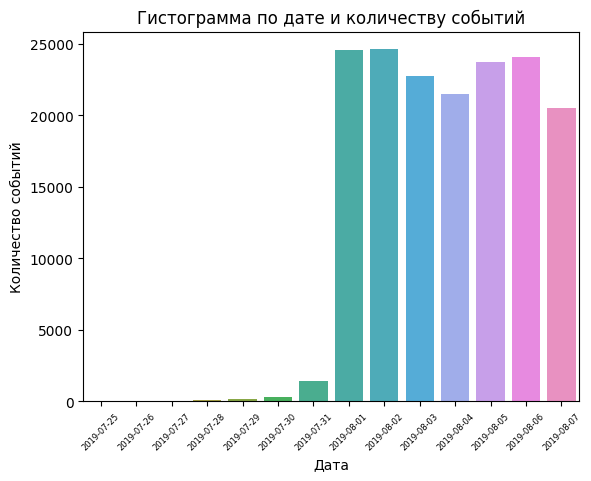

In [ ]:
# Строим гистограмму

ax = sns.barplot(data = df_count_event_day,
            x = 'event_date',
            y = 'count_event_day')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 6);
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Гистограмма по дате и количеству событий')
plt.show()

In [ ]:
# С учетом полученных результатов по количеству событий в день
# оставим в выборке данные с 2019-08-01

df_ok = df[df.event_date >= dt.datetime(2019, 8, 1).date()]

In [ ]:
# Проверим соотношение пользователей по группам

df_ok.group_id.value_counts()

248    84563
247    77022
Name: group_id, dtype: int64

**Шаг 4.** Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

In [ ]:
# Распределение событий: какие события и в каком количестве

df_ok.groupby('event_name').agg(count_event = ('device_id', 'count')).\
reset_index().\
sort_values(by = 'count_event', ascending = False)

,event_name,count_event
1,MainScreenAppear,79652
2,OffersScreenAppear,31566
0,CartScreenAppear,27613
3,PaymentScreenSuccessful,22066
4,Tutorial,688


In [ ]:
# Сколько уникальных пользователей совершали каждое из этих событий?

df_ok.groupby('event_name').agg(count_users = ('device_id', 'nunique')).\
reset_index().\
sort_values(by = 'count_users', ascending = False)

,event_name,count_users
1,MainScreenAppear,4969
2,OffersScreenAppear,3051
0,CartScreenAppear,2468
3,PaymentScreenSuccessful,2339
4,Tutorial,562


In [ ]:
df_ok

,event_name,device_id,event_time,group_id,event_date
1949,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
1950,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01
1951,MainScreenAppear,4899590676214355127,2019-08-01 00:11:28,247,2019-08-01
1952,OffersScreenAppear,4899590676214355127,2019-08-01 00:11:30,247,2019-08-01
1953,OffersScreenAppear,4899590676214355127,2019-08-01 00:12:36,247,2019-08-01
...,...,...,...,...,...
163817,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247,2019-08-07
163818,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248,2019-08-07
163819,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248,2019-08-07
163820,OffersScreenAppear,5317814261427487562,2019-08-07 21:10:08,248,2019-08-07


In [ ]:
# Построение воронки
# В разрезе групп посчитаем количество уникальных пользователей, совершивших события

# делаем фильтр по 247 группе, далее группируем по событиям,
# считаем кол-во уникальных пользователей, кот. совершили то или иное событие,
# сделали сортировку, далее тоже самое с 248 группой,
# и применили для объединения двух датафреймов pd.merge

df_all_groups = pd.merge(df_ok[df_ok.group_id == 247].groupby('event_name').\
         agg(count_users_in_247 = ('device_id', 'nunique')).\
         reset_index().\
         sort_values(by = 'count_users_in_247', ascending = False),
         df_ok[df_ok.group_id == 248].groupby('event_name').\
         agg(count_users_in_248 = ('device_id', 'nunique')).\
         reset_index().\
         sort_values(by = 'count_users_in_248', ascending = False))

In [ ]:
df_all_groups

,event_name,count_users_in_247,count_users_in_248
0,MainScreenAppear,2476,2493
1,OffersScreenAppear,1520,1531
2,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181
4,Tutorial,283,279


Для построения воронки продаж можно исключить из датафрейма событие Руководство (Tutorial), так как от события "Появление главного экрана" (MainScreenAppear) до события "Экран оплаты" (PaymentScreenSuccessful) данное событие особой роли не играет.

In [ ]:
# Удаляем событие Tutorial из датафрейма

select_event = ['MainScreenAppear', 'OffersScreenAppear',
              'CartScreenAppear', 'PaymentScreenSuccessful']
df_all_groups = df_all_groups.loc[df_all_groups.event_name.isin(select_event)]

In [ ]:
# Строим воронку сразу для двух групп с помощью plotly

from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа 247',
    orientation = "h",
    y = df_all_groups['event_name'],
    x = df_all_groups['count_users_in_247'],
    textposition = "inside",
    textinfo = "value+percent total+percent previous"))

fig.add_trace(go.Funnel(
    name = 'Группа 248',
    orientation = "h",
    y = df_all_groups['event_name'],
    x = df_all_groups['count_users_in_248'],
    textposition = "inside",
    textinfo = "value+percent total+percent previous"))

fig.show()

**Шаг 5.** Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

In [ ]:
# Посмотрим сколько пользователей в каждой группе

# воспользуемся группировкой по признаку group_id и
# считаем для нового столбца уникальные значения по device_id

count_users = df_ok.groupby('group_id').agg(unique_users_group = ('device_id', 'nunique'))
count_users

,unique_users_group
group_id,
247,2513
248,2537


In [ ]:
# Посчитаем долю пользователей, совершивших каждое из событий

# посмотрим в разрезе групп количество уникальных пользователей, совершивших события
df_all_groups

,event_name,count_users_in_247,count_users_in_248
0,MainScreenAppear,2476,2493
1,OffersScreenAppear,1520,1531
2,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181


In [ ]:
# Считаем долю пользователей, совершивших каждое из событий

# добавим два столбца с долей пользователей по двум группам

df_all_groups['percent_user_group_247'] = df_all_groups['count_users_in_247'] / count_users.loc[247][0]
df_all_groups['percent_user_group_248'] = df_all_groups['count_users_in_248'] / count_users.loc[248][0]

<ipython-input-29-f17fdfda8cc1>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-f17fdfda8cc1>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_all_groups

,event_name,count_users_in_247,count_users_in_248,percent_user_group_247,percent_user_group_248
0,MainScreenAppear,2476,2493,0.985277,0.982657
1,OffersScreenAppear,1520,1531,0.604855,0.603469
2,CartScreenAppear,1238,1230,0.492638,0.484825
3,PaymentScreenSuccessful,1158,1181,0.460804,0.465510


In [ ]:
# Проверяем гипотезу о наличие значимых отличий по результатам теста

**Гипотезы на нормальность в данном случае нет смысла проверять, так как распределение биномиальное**.

Сформулируем гипотезы о наличие значимых отличий по результатам теста:

Гипотеза H_0 : нет статистически значимых отличий в количестве пользователей, совершивших каждое событие по группам 247 и 248.

Гипотеза H_1 : имеются статистически значимые отличия в количестве пользователей, совершивших каждое событие по группам 247 и 248.

In [ ]:
# Меняем индексы: вместо 0, 1, 2, 3 ставим event_name,
# для того чтобы использовать это в формуле ниже
df_all_groups.index = df_all_groups.event_name

In [ ]:
# Смотрим, что получилось
df_all_groups

,event_name,count_users_in_247,count_users_in_248,percent_user_group_247,percent_user_group_248
event_name,,,,,
MainScreenAppear,MainScreenAppear,2476,2493,0.985277,0.982657
OffersScreenAppear,OffersScreenAppear,1520,1531,0.604855,0.603469
CartScreenAppear,CartScreenAppear,1238,1230,0.492638,0.484825
PaymentScreenSuccessful,PaymentScreenSuccessful,1158,1181,0.460804,0.465510


In [ ]:
# Проверили, взяли число по индексу MainScreenAppear
df_all_groups.loc['MainScreenAppear', 'percent_user_group_247']

0.9852765618782332

In [ ]:
# Проверяем гипотезу о наличие значимых отличий по результатам теста.

# Данная формула приведена на лекции:
# сначала считаем наблюдаемые значения нашего критерия,т.е. считаем формулу для биноминального распределения,
# далее задаем нормальное стандартное распределение с матожиданием = 0 и дисперсией = 1,
# далее считаем  p_value, оно считается через нормальное распределение,
# выводим результаты в соответствии со значениями p_value

import math
import scipy.stats as st


def z_test(group1, group2, event, alpha):
    p1_ev = df_all_groups.loc[event, group1]
    p2_ev = df_all_groups.loc[event, group2]
    p1_us = count_users.loc[247][0]
    p2_us = count_users.loc[248][0]
    p1 = p1_ev / p1_us
    p2 = p2_ev / p2_us
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us)
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Группы {} и {}. Событие -- {}. P-значение --  {:.2f}. Уровень значимости -- {}'.format(group1, group2, event, p_value, alpha))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу -- между долями есть значимая разница.")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.")


In [ ]:
# Используем функцию, смотрим на результат

for event in df_all_groups.index:
    z_test('count_users_in_247', 'count_users_in_248', event, 0.05)

Группы count_users_in_247 и count_users_in_248. Событие -- MainScreenAppear. P-значение --  0.46. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Группы count_users_in_247 и count_users_in_248. Событие -- OffersScreenAppear. P-значение --  0.92. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Группы count_users_in_247 и count_users_in_248. Событие -- CartScreenAppear. P-значение --  0.58. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
Группы count_users_in_247 и count_users_in_248. Событие -- PaymentScreenSuccessful. P-значение --  0.74. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
